In [ ]:
import spikeinterface.full as si
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import warnings
from pprint import pprint
print(f"SpikeInterface version: {si.__version__}")
warnings.simplefilter("ignore")
%matplotlib inline

SpikeInterface version: 0.102.0


In [2]:
si.read_binary?

Init signature:
si.read_binary(
    file_paths,
    sampling_frequency,
    dtype,
    num_channels=None,
    t_starts=None,
    channel_ids=None,
    time_axis=0,
    file_offset=0,
    gain_to_uV=None,
    offset_to_uV=None,
    is_filtered=None,
    num_chan=None,
)
Docstring:     
RecordingExtractor for a binary format

Parameters
----------
file_paths : str or Path or list
    Path to the binary file
sampling_frequency : float
    The sampling frequency
num_channels : int
    Number of channels
num_chan : int [deprecated, use num_channels instead, will be removed as early as v0.100.0]
    Number of channels
dtype : str or dtype
    The dtype of the binary file
time_axis : int, default: 0
    The axis of the time dimension
t_starts : None or list of float, default: None
    Times in seconds of the first sample for each segment
channel_ids : list, default: None
    A list of channel ids
file_offset : int, default: 0
    Number of bytes in the file to offset by during memmap instanti

In [2]:
# read recording
base_folder = Path("D:\si_test\LE24_240604_150112")
data_path = base_folder / "amplifier.dat"
record_params = dict(
    sampling_frequency=20000, dtype='int16', num_channels=64,
    gain_to_uV=0.195
)
pprint(record_params)
raw_data = si.read_binary(data_path, **record_params)
raw_data

{'dtype': 'int16',
 'gain_to_uV': 0.195,
 'num_channels': 64,
 'sampling_frequency': 20000}


BinaryRecordingExtractor: 64 channels - 20.0kHz - 1 segments - 9,608,400 samples 
                          480.42s (8.01 minutes) - int16 dtype - 1.15 GiB
  file_paths: ['D:\\si_test\\LE24_240604_150112\\amplifier.dat']

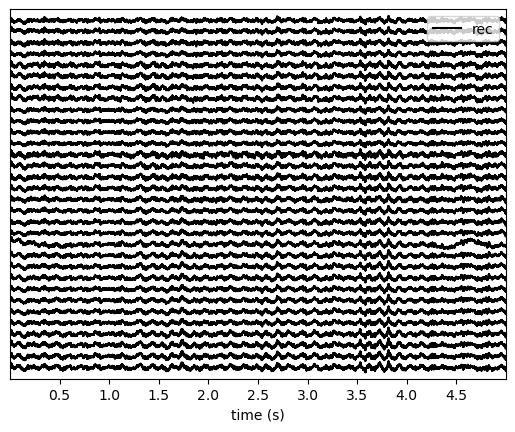

In [3]:
# visualize raw data
w_ts = si.plot_traces(raw_data, time_range=(0, 5), channel_ids=tuple(range(0, 32)))
# visualize spike data
# w_rs = sw.plot_rasters(sorting_true, time_range=(0, 5))

In [4]:
# prepare tetrodes
from probeinterface import Probe, ProbeGroup
from probeinterface import generate_tetrode
from probeinterface.plotting import plot_probe, plot_probe_group
probegroup = ProbeGroup()
num_tetrode = 16;  num_channel = num_tetrode*4;
for i in range(num_tetrode):
    tetrode = generate_tetrode()
    # tetrode.set_device_channel_indices(np.arange(4) + i * 4)
    tetrode.move([i * 50, 0])
    probegroup.add_probe(tetrode)
probegroup.set_global_device_channel_indices(np.arange(num_channel))
# check probe info
df = probegroup.to_dataframe()
df
# alternative: silicon probe
# import probeinterface as pi
# from probeinterface.plotting import plot_probe
# manufacturer = 'cambridgeneurotech'
# probe_name = 'ASSY-236-H5'
# probe = pi.get_probe(manufacturer, probe_name)
# print(probe)



,probe_index,x,y,contact_shapes,radius,shank_ids,contact_ids
0,0,1.000000e+01,0.000000e+00,circle,6.0,,
1,0,6.123234e-16,1.000000e+01,circle,6.0,,
2,0,-1.000000e+01,1.224647e-15,circle,6.0,,
3,0,-1.836970e-15,-1.000000e+01,circle,6.0,,
4,1,6.000000e+01,0.000000e+00,circle,6.0,,
...,...,...,...,...,...,...,...
59,14,7.000000e+02,-1.000000e+01,circle,6.0,,
60,15,7.600000e+02,0.000000e+00,circle,6.0,,
61,15,7.500000e+02,1.000000e+01,circle,6.0,,
62,15,7.400000e+02,1.224647e-15,circle,6.0,,


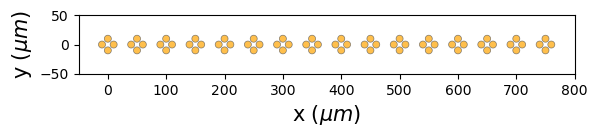

In [5]:
# plot probe
plot_probe_group(probegroup, with_contact_id=True, same_axes=True)

In [6]:
# set group to recording
recording = raw_data.set_probegroup(probegroup, group_mode='by_probe')
# get group
print('channel group:')
print(recording.get_channel_groups())
# another method
# print(recording.get_property('group'))

channel group:
[ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5
  6  6  6  6  7  7  7  7  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11
 12 12 12 12 13 13 13 13 14 14 14 14 15 15 15 15]


In [7]:
# set parameters
global_job_kwargs = dict(n_jobs=-1, progress_bar=True)
si.set_global_job_kwargs(**global_job_kwargs)

In [14]:
# information of recording
# channel_ids = raw_data.get_channel_ids()
# fs = raw_data.get_sampling_frequency()
# num_chan = raw_data.get_num_channels()
# num_seg = raw_data.get_num_segments()

# print("Channel ids:", channel_ids)
# print("Sampling frequency:", fs)
# print("Number of channels:", num_chan)
# print("Number of segments:", num_seg)

Channel ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Sampling frequency: 20000.0
Number of channels: 64
Number of segments: 1


In [8]:
recording_f = si.bandpass_filter(recording, freq_min=300, freq_max=6000)
recording_cmr = si.common_reference(
    recording_f, reference="global",
    operator="median"
)
recording_pre = recording_cmr.save(format="binary")
print(recording_pre)

Use cache_folder=C:\Users\Jeff\AppData\Local\Temp\spikeinterface_cache\tmpnp2so5bk\RYFXHJ1W
write_binary_recording 
n_jobs=24 - samples_per_chunk=20,000 - chunk_memory=2.44 MiB - total_memory=58.59 MiB - chunk_duration=1.00s


write_binary_recording:   0%|          | 0/481 [00:00<?, ?it/s]

BinaryFolderRecording: 64 channels - 20.0kHz - 1 segments - 9,608,400 samples 
                       480.42s (8.01 minutes) - int16 dtype - 1.15 GiB


In [9]:
%matplotlib widget
w = si.plot_traces({"filtered": recording_pre, "common": recording_pre},
                   mode='map', time_range=[10, 10.1], backend="ipywidgets"
                   )

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [10]:
# data compression
n_cpus = os.cpu_count()
n_jobs = n_cpus
job_kwargs = dict(n_jobs=n_jobs, progress_bar=True)

In [36]:
si.run_sorter_by_property?

Signature:
si.run_sorter_by_property(
    sorter_name,
    recording,
    grouping_property,
    folder,
    mode_if_folder_exists=None,
    engine='loop',
    engine_kwargs={},
    verbose=False,
    docker_image=None,
    singularity_image=None,
    working_folder: 'None' = None,
    **sorter_params,
)
Docstring:
Generic function to run a sorter on a recording after splitting by a "grouping_property" (e.g. "group").

Internally, the function works as follows:
    * the recording is split based on the provided "grouping_property" (using the "split_by" function)
    * the "run_sorters" function is run on the split recordings
    * sorting outputs are aggregated using the "aggregate_units" function
    * the "grouping_property" is added as a property to the SortingExtractor

Parameters
----------
sorter_name : str
    The sorter name
recording : BaseRecording
    The recording to be sorted
grouping_property : object
    Property to split by before sorting
folder : str | Path
    The wor

In [ ]:
# to perform sorting, we need to split 'recording' data first
# we can perform automatic splitting
# TODO 1: optimize parameters of sorting
# TODO 2: select the best sortor, maybe mountainsort
# TODO 3: if the best sorter is kilosort series, configure CUDA acceleration
sortings = si.run_sorter_by_property(
    sorter_name='kilosort', recording=recording_pre,
    grouping_property='group', 
    # working_folder='working_path',
    folder=base_folder, docker_image=True,
    **job_kwargs
)
print(f'KS found {len(sortings.get_unit_ids())} units')

KS found 420 units


In [12]:
print(sortings)

UnitsAggregationSorting: 420 units - 1 segments - 20.0kHz


In [ ]:
# use SortingAnalyzer object to perform postprocessing
# here: save it in binary format
analyzer = si.create_sorting_analyzer(sorting=sortings, recording=recording_pre,
                                      format='binary_folder', folder='analyzer_ks2'
                                      )
# TODO: absolute path

estimate_sparsity:   0%|          | 0/481 [00:00<?, ?it/s]

create_sorting_analyzer: recording does not have scaling to uV, forcing return_scaled=False


In [ ]:
# calculate waveform
# sample some spikes (by default max_spiks_per_unit=500)
# results stored in ./analyzer_ks2/extensions/waveforms
# analyzer.compute("random_spikes") # TODO what is this???
analyzer.compute("waveforms") 

compute_waveforms:   0%|          | 0/481 [00:00<?, ?it/s]

In [18]:
unit_id0 = analyzer.unit_ids[0]  # direct get ids
waveforms = analyzer.get_extension("waveforms").get_data()[unit_id0]  # this is how we get data from extensions
print(waveforms.shape)

(60, 17)


In [ ]:
# other properties we can get
analyzer.compute("noise_levels")
analyzer.compute("templates")
analyzer.compute("spike_amplitudes")

In [ ]:
# some extensions have parameters we can tune
analyzer.compute("unit_locations", method="center_of_mass")
analyzer.compute("spike_locations", ms_before=0.5)
analyzer.compute("correlograms", bin_ms=0.1)
analyzer.compute("template_similarity", method="cosine_similarity")

In [ ]:
# a simplified version of syntax to compute properties
extensions_to_compute = [
    # "random_spikes",
    # "waveforms",
    "noise_levels",
    "templates",
    "spike_amplitudes",
    "unit_locations",
    "spike_locations",
    "correlograms",
    "template_similarity"
]

extension_params = {
    "unit_locations": {"method": "center_of_mass"},
    "spike_locations": {"ms_before": 0.1},
    "correlograms": {"bin_ms": 0.1},
    "template_similarity": {"method": "cosine_similarity"}
}

analyzer.compute(extensions_to_compute, extension_params=extension_params) # 同样会直接保存到子文件夹中

Compute : spike_amplitudes + spike_locations:   0%|          | 0/481 [00:00<?, ?it/s]

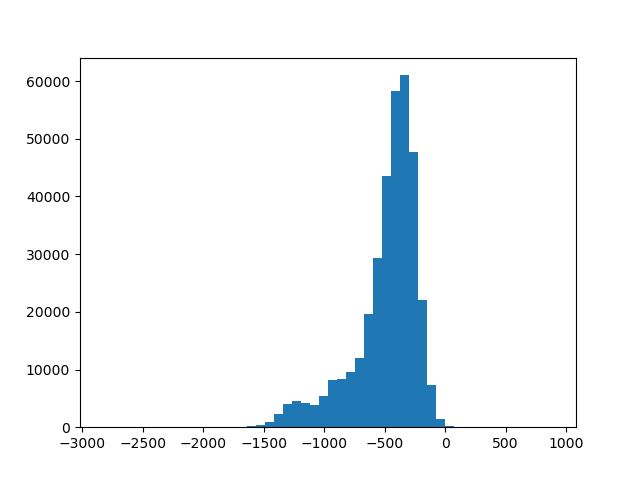

In [ ]:
# plot distirbution of amplitudes of units
amplitudes = analyzer.get_extension("spike_amplitudes").get_data()
plt.hist(amplitudes, bins=50)
plt.show()

In [ ]:
# 其他相关的命令 用到时再执行
# print(analyzer.get_saved_extension_names())
# print(analyzer.get_loaded_extension_names())
# analyzer.delete_extension("spike_amplitudes")  # 会直接删除文件夹中的文件

# 从文件夹目录直接读取 SortingAnalyzer 的方式
# sorting_analyzer_path = './analyzer_ks2'
# analyzer_loaded = si.load_sorting_analyzer(sorting_analyzer_path)
# print(analyzer_loaded.get_loaded_extension_names())

In [ ]:
# after computing all parameters, we can compute quality metrics
qm_params = si.get_default_qm_params()
pprint(qm_params)

{'amplitude_cutoff': {'amplitudes_bins_min_ratio': 5,
                      'histogram_smoothing_value': 3,
                      'num_histogram_bins': 100,
                      'peak_sign': 'neg'},
 'amplitude_cv': {'amplitude_extension': 'spike_amplitudes',
                  'average_num_spikes_per_bin': 50,
                  'min_num_bins': 10,
                  'percentiles': (5, 95)},
 'amplitude_median': {'peak_sign': 'neg'},
 'drift': {'direction': 'y',
           'interval_s': 60,
           'min_num_bins': 2,
           'min_spikes_per_interval': 100},
 'firing_range': {'bin_size_s': 5, 'percentiles': (5, 95)},
 'firing_rate': {},
 'isi_violation': {'isi_threshold_ms': 1.5, 'min_isi_ms': 0},
 'nearest_neighbor': {'max_spikes': 10000, 'n_neighbors': 5},
 'nn_isolation': {'max_spikes': 10000,
                  'min_fr': 0.0,
                  'min_spikes': 10,
                  'n_components': 10,
                  'n_neighbors': 4,
                  'peak_sign': 'neg',
       

In [ ]:
# to change some parameters of quality metrics (if the recording is short)
# qm_params["presence_ratio"]["bin_duration_s"] = 1
# qm_params["amplitude_cutoff"]["num_histogram_bins"] = 5
# qm_params["drift"]["interval_s"] = 2
# qm_params["drift"]["min_spikes_per_interval"] = 2

In [ ]:
# compute quality metrics is in the same way as computing extensions
analyzer.compute("quality_metrics", qm_params)
analyzer.get_extension("quality_metrics").get_data()
# quality metrics is also saved in subfolder

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,...,amplitude_cv_median,amplitude_cv_range,sync_spike_2,sync_spike_4,sync_spike_8,firing_range,drift_ptp,drift_std,drift_mad,sd_ratio
0,569,1.18438,1.0,15.404955,0.0,0,0.0,0,<NA>,0.000457,...,0.164378,0.069247,0.059754,0.0,0,7.05,<NA>,<NA>,<NA>,1.523426
1,937,1.950377,1.0,9.196789,0.182398,1,0.327092,1,<NA>,0.002927,...,0.20421,0.081577,0.0619,0.0,0,5.25,0.159833,0.031271,0.045793,1.323444
2,742,1.544482,1.0,7.858597,0.0,0,0.0,0,<NA>,0.000584,...,0.233357,0.092148,0.053908,0.0,0,5.8,<NA>,<NA>,<NA>,1.552294
3,1455,3.0286,1.0,8.266892,0.0,0,0.0,0,0.175,0.001575,...,0.239492,0.131987,0.043986,0.0,0,11.85,0.241597,0.07766,0.051121,1.330967
4,1640,3.41368,1.0,5.975553,0.416783,7,0.0,0,0.21,0.001302,...,0.262335,0.092612,0.059146,0.0,0,6.1,0.122983,0.036517,0.025311,1.097203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,156,0.324716,1.0,15.659351,0.0,0,0.0,0,<NA>,<NA>,...,<NA>,<NA>,0.108974,0.0,0,1.3,<NA>,<NA>,<NA>,2.123311
416,381,0.793056,1.0,9.991098,0.0,0,0.0,0,<NA>,<NA>,...,<NA>,<NA>,0.073491,0.0,0,2.05,<NA>,<NA>,<NA>,1.791351
417,302,0.628617,1.0,9.649481,0.0,0,0.0,0,<NA>,<NA>,...,<NA>,<NA>,0.05298,0.0,0,1.8,<NA>,<NA>,<NA>,1.575624
418,230,0.478748,1.0,8.503281,0.0,0,0.0,0,<NA>,<NA>,...,<NA>,<NA>,0.06087,0.0,0,1.2,<NA>,<NA>,<NA>,0.896367


In [ ]:
# using sortingview, we can visualize the sorting summary and quality metrics plot
# this will generate a html file
# this need sortingview installed and kachery-cloud constructed
# 神奇的花哨功能
# w1 = si.plot_quality_metrics(analyzer, display=False, backend="sortingview")
# w2 = sw.plot_sorting_summary(analyzer, display=False, curation=True, backend="sortingview")
# uri = "sha1://68cb54a9aaed2303fb82dedbc302c853e818f1b6"
# sorting_curated_sv = si.apply_sortingview_curation(sorting, uri_or_json=uri)
# print(sorting_curated_sv)
# print(sorting_curated_sv.get_property("accept"))

In [26]:
# 一般流程是这个
# export data locally to Phy
si.export_to_phy(analyzer, "phy_folder_for_ks2", verbose=True)

write_binary_recording:   0%|          | 0/481 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/420 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/420 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/481 [00:00<?, ?it/s]

Run:
phy template-gui  C:\Users\Jeff\OneDrive\Code\SpikeInterface\phy_folder_for_ks2\params.py


In [ ]:
# then we can use phy to curate the sorting results
# phy template-gui  C:\Users\Jeff\OneDrive\Code\SpikeInterface\phy_folder_for_ks2\params.py

In [ ]:
# after curating with Phy, the data can be reloaded to SpikeInterface
# we can exclude noise units
sorting_curated = si.read_phy("phy_folder_for_ks2", exclude_cluster_groups=["noise"])

In [ ]:
# this part is unused for now
# automatic curation using quality metrics
# example here: according to SNR threshold

# qm_data = analyzer.get_extension("quality_metrics").get_data()
# keep_mask = (qm_data["snr"] > 10) & (qm_data["isi_violations_ratio"] < 0.01)
# print("Mask:", keep_mask.values)
# sorting_curated_auto = sorting_curated.select_units(sorting_curated.unit_ids[keep_mask])
# print(sorting_curated_auto)

In [ ]:
# some TODO
# the final part: compare outputs of different sorters or between ground truth
# this part is useful for selecting the best sorter

In [ ]:
# 下面的部分代码都是来自于旧版本的 tutorial, 0.99 版本的, 0.101 版本的 SI 已经不再支持
pi.get_available_pathways()
probe.wiring_to_device('cambridgeneurotech_mini-amp-64')
fig, ax = plt.subplots(figsize=(14, 10))
plot_probe(probe, ax=ax)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 500)
fig, ax = plt.subplots(figsize=(14, 10))
plot_probe(probe, ax=ax, with_contact_id=True, with_device_index=True,)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 300)
probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]
raw_rec = full_raw_rec.set_probe(probe)
raw_rec
probe_rec = raw_rec.get_probe()
probe_rec.to_dataframe(complete=True).loc[:, ["contact_ids", "device_channel_indices"]]
fig, ax = plt.subplots()
si.plot_probe_map(raw_rec, with_channel_ids=True, ax=ax)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 300)
%matplotlib widget
si.plot_traces(raw_rec, backend="ipywidgets", mode='line', channel_ids=raw_rec.channel_ids[::8])
print("Properties:\n", list(raw_rec.get_property_keys()))
brain_area_property_values = ['CA1']*32 + ['CA3']*32
print(brain_area_property_values)
raw_rec.set_property(key='brain_area', values=brain_area_property_values)
raw_rec.get_property_keys()
raw_rec.get_property("brain_area")
raw_rec.annotate(description="Dataset for SI tutorial")
print(raw_rec.get_annotation_keys())
print(raw_rec._annotations['description'])

Traces shape: (60000, 72)
ASSY-236-H5 - cambridgeneurotech - 64ch - 1shanks


AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

Properties:
 ['gain_to_uV', 'offset_to_uV', 'channel_names', 'contact_vector', 'location', 'group']
['CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3']
['is_filtered', 'probe_0_planar_contour', 'description']
Dataset for SI tutorial


# 2. Preprocessing <a class="anchor" id="preprocessing"></a>

In [3]:
recording_f = si.bandpass_filter(raw_rec, freq_min=300, freq_max=9000)
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')
w = si.plot_traces({"filtered": recording_f, "common": recording_cmr}, mode='map',
                   time_range=[10, 10.1], backend="ipywidgets")
bad_channel_ids, channel_labels = si.detect_bad_channels(recording_f, method='coherence+psd')
print('bad_channel_ids', bad_channel_ids)
print('channel_labels', channel_labels)
recording_good_channels_f = recording_f.remove_channels(bad_channel_ids)
recording_good_channels = si.common_reference(recording_good_channels_f, reference='global', operator='median')
print(recording_good_channels)
print(recording_good_channels.channel_ids)
w = si.plot_traces(recording_good_channels, mode='map',
                   time_range=[10, 10.1],
                   backend="ipywidgets")
fs = recording_cmr.get_sampling_frequency()
recording_sub = recording_good_channels.frame_slice(start_frame=0*fs, end_frame=300*fs)
recording_sub
raw_rec_sub = raw_rec.frame_slice(start_frame=0*fs, end_frame=300*fs)
raw_rec_sub

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

bad_channel_ids ['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH40' 'CH57' 'CH58'
 'CH59' 'CH60' 'CH61' 'CH64']
channel_labels ['dead' 'dead' 'dead' 'dead' 'dead' 'dead' 'dead' 'dead' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'noise'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'dead' 'dead' 'dead' 'dead'
 'dead' 'good' 'good' 'dead']
CommonReferenceRecording: 49 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                          300.00s (5.00 minutes) - int16 dtype - 841.14 MiB
['CH9' 'CH10' 'CH11' 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH18'
 'CH19' 'CH20' 'CH21' 'CH22' 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28'
 'CH29' 'CH30' 'CH31' 'CH32' 'CH33' 'CH34' 'CH35' 'CH36' 'CH37' 'CH38'
 'CH39' 'CH41' 'CH42' 'CH43' 'CH44' 'CH45'

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

FrameSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                     300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

In [4]:
n_cpus = os.cpu_count()
n_jobs = n_cpus - 4
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="1s", progress_bar=True)
# kwargs: keyword arguments
if (base_folder / "preprocessed").is_dir():
    recording_saved = si.load_extractor(base_folder / "preprocessed")
else:
    recording_saved = recording_sub.save(folder=base_folder / "preprocessed", **job_kwargs)
recording_saved
!ls -llh {base_folder}/preprocessed  # linux 命令, 列出 'base_folder/preprocessed' 目录下的所有文件
print(f'Saved channels ids:\n{recording_saved.get_channel_ids()}')
recording_loaded = si.load_extractor(base_folder / "preprocessed")
print(f'Loaded channels ids:\n{recording_loaded.get_channel_ids()}')
# import numcodecs
if (base_folder / "preprocessed_compressed.zarr").is_dir():
    recording_saved = si.read_zarr(base_folder / "preprocessed_compressed.zarr")
else:
    import numcodecs
    compressor = numcodecs.Blosc(cname="zstd", clevel=9, shuffle=numcodecs.Blosc.BITSHUFFLE)
    recording_saved = recording_sub.save(format="zarr", folder=base_folder / "preprocessed_compressed.zarr",
                                         compressor=compressor,
                                         **job_kwargs)
!du -sh {base_folder}/preprocessed_compressed.zarr  # du 命令用来获取指定目录或文件的大小
!du -sh {base_folder}/preprocessed  # 这里是为了展现压缩率

'ls' is not recognized as an internal or external command,
operable program or batch file.


Saved channels ids:
['CH9' 'CH10' 'CH11' 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH18'
 'CH19' 'CH20' 'CH21' 'CH22' 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28'
 'CH29' 'CH30' 'CH31' 'CH32' 'CH33' 'CH34' 'CH35' 'CH36' 'CH37' 'CH38'
 'CH39' 'CH41' 'CH42' 'CH43' 'CH44' 'CH45' 'CH46' 'CH47' 'CH48' 'CH49'
 'CH50' 'CH51' 'CH52' 'CH53' 'CH54' 'CH55' 'CH56' 'CH62' 'CH63']
Loaded channels ids:
['CH9' 'CH10' 'CH11' 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH18'
 'CH19' 'CH20' 'CH21' 'CH22' 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28'
 'CH29' 'CH30' 'CH31' 'CH32' 'CH33' 'CH34' 'CH35' 'CH36' 'CH37' 'CH38'
 'CH39' 'CH41' 'CH42' 'CH43' 'CH44' 'CH45' 'CH46' 'CH47' 'CH48' 'CH49'
 'CH50' 'CH51' 'CH52' 'CH53' 'CH54' 'CH55' 'CH56' 'CH62' 'CH63']


'du' is not recognized as an internal or external command,
operable program or batch file.
'du' is not recognized as an internal or external command,
operable program or batch file.


# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

In [5]:
si.available_sorters()
si.installed_sorters()

['simple', 'spykingcircus2', 'tridesclous', 'tridesclous2']

### Run sorter in container

In [7]:
# run spike sorting on entire recording
sorting_KS = si.run_sorter('kilosort', recording_saved, 
                           output_folder=base_folder / 'results_KS', 
                           verbose=True, 
                           docker_image=True, 
                           **job_kwargs)
sorting_KS
print(f'KS found {len(sorting_KS.get_unit_ids())} units')

installation_mode='auto' switching to installation_mode: 'github'
Starting container
Installing spikeinterface with github in container
Running kilosort sorter inside spikeinterface/kilosort-compiled-base
Stopping container
KS found 240 units


# 5. Postprocessing <a class="anchor" id="waveforms"></a>

In [8]:
# prepare data for this part
recording_saved = si.load_extractor(base_folder / "preprocessed")
sorting = sorting_KS

In [50]:
si.create_sorting_analyzer?

Signature:
si.create_sorting_analyzer(
    sorting,
    recording,
    format='memory',
    folder=None,
    sparse=True,
    sparsity=None,
    return_scaled=True,
    overwrite=False,
    backend_options=None,
    **sparsity_kwargs,
) -> "'SortingAnalyzer'"
Docstring:
Create a SortingAnalyzer by pairing a Sorting and the corresponding Recording.

This object will handle a list of AnalyzerExtension for all the post processing steps like: waveforms,
templates, unit locations, spike locations, quality metrics ...

This object will be also use used for plotting purpose.


Parameters
----------
sorting : Sorting
    The sorting object
recording : Recording
    The recording object
folder : str or Path or None, default: None
    The folder where analyzer is cached
format : "memory | "binary_folder" | "zarr", default: "memory"
    The mode to store analyzer. If "folder", the analyzer is stored on disk in the specified folder.
    The "folder" argument must be specified in case of mode "fold

In [10]:
# [NEW] 1.1. create analyzer object (in memory, and save later)
analyzer = si.create_sorting_analyzer(
    sorting=sorting, 
    recording=recording_saved
    )
analyzer.save_as(
    format="zarr",  # or "binary_folder"
    folder=base_folder / "sorting_analyzer_zarr"
)

estimate_sparsity:   0%|          | 0/300 [00:00<?, ?it/s]

SortingAnalyzer: 49 channels - 240 units - 1 segments - zarr - sparse - has recording
Loaded 0 extensions

In [13]:
# [NEW] 1.2. create analyzer object (and save locally)
# use this version
analyzer = si.create_sorting_analyzer(
    sorting=sorting,
    recording=recording_saved,
    folder=base_folder / "sorting_analyzer",
    format="binary_folder",  # or "zarr"
    sparse=True  # 可以选择是否需要 sparse
)

estimate_sparsity:   0%|          | 0/300 [00:00<?, ?it/s]

In [14]:
# [NEW] 1.3. load analyzer from saved folder
analyzer = si.load_sorting_analyzer(
    folder= base_folder / "sorting_analyzer"
)

In [15]:
# [NEW] 2.1. 使用 extension 进行后处理
# [1] 注意计算的内容之间是有先后顺序的, 一些参数的计算依赖于它的父项
# [2] 每次计算都会强制删除可能已存在的参数重新计算
# [3] 对父项的重新计算 / 删除会强制自动删除其子项参数以保证参数一致性
# [4] 如果 analyzer 已经被保存在本地, 则所有计算内容都会自动保存
analyzer.compute("random_spikes")  # 没懂 random spikes 是干啥的
analyzer.compute("waveforms")
analyzer.compute("templates")  # 还有 all_templates???
analyzer.compute(
    "spike_amplitudes",
    peak_sign="pos"
)
# 其他参数 (待添加)
# spike train
# sparsity 和 sparsity 条件下的波形
# 绘制 waveform
# 显示已经保存在本地的参数
analyzer.get_saved_extension_names()

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

['random_spikes', 'spike_amplitudes', 'templates', 'waveforms']

In [61]:
# [NEW] 2.2. 如果从文件中读取的 analyzer 存在问题时
# 可能会使用以下语句单独导入或删除某些参数
analyzer.get_loaded_extension_names()
analyzer.load_extension(
    extension_name="spike_amplitudes"
)
analyzer.has_extension(
    extension_name="spike_amplitudes"
)
# This also deletes any children such as spike_amplitudes
analyzer.delete_extension(
    extension_name="templates"
)

In [22]:
# [NEW] 3.1. 获取 extension 计算的结果
wv = analyzer.get_extension(
    extension_name="waveforms"
)
wv_data = wv.get_data()
# ul = analyzer.get_extension(
#     extension_name="unit_locations"
# )
# ul_data = ul.get_data()
# # 3.2. 获取 extension 计算的参数
# ul_params = ul.params
wv_params = wv.get_data()

# 6. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `postprocessing` module.


See also : https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [ ]:
pc = si.compute_principal_components(we, n_components=3, load_if_exists=False, **job_kwargs)

In [ ]:
available_extension_names = sorting_analyzer.get_loaded_extension_names()

AttributeError: module 'spikeinterface.full' has no attribute 'sorting_analyzer'

In [34]:
pc0 = pc.get_projections(unit_id=0)
print(f"PC scores shape: {pc0.shape}")
all_labels, all_pcs = pc.get_all_projections()
print(f"All PC scores shape: {all_pcs.shape}")

AttributeError: 'numpy.ndarray' object has no attribute 'get_projections'

In [25]:
pc

array([[[-0.12049486,  0.22618708,  0.5280675 , ...,  0.40697625,
          0.24794905,  0.        ],
        [ 0.18074714,  0.04203514, -0.09824314, ..., -0.10468819,
         -0.01779368,  0.        ],
        [-0.31905347, -0.12935774, -0.02731553, ...,  0.12108496,
         -0.11225367,  0.        ]],

       [[ 0.6976387 ,  0.31165355,  0.13896017, ...,  0.44065353,
          0.42389414,  0.        ],
        [ 0.659916  ,  0.74019694, -0.5639803 , ...,  0.5846022 ,
         -0.7356014 ,  0.        ],
        [ 4.0931687 ,  0.37067536, -0.07616394, ..., -0.42979032,
          0.15593718,  0.        ]],

       [[-3.5197668 ,  0.11882715,  0.39084807, ..., -0.06279539,
         -0.20348547,  0.        ],
        [ 0.33097908,  0.34563428, -0.25067922, ...,  0.02832284,
         -0.22235928,  0.        ],
        [-0.33068323, -0.18919796, -0.3355254 , ...,  0.17669834,
          0.1458164 ,  0.        ]],

       ...,

       [[ 0.61715   ,  0.48778278,  0.8193411 , ...,  0.5039513

For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 

## WaveformExtensions

When we compute PCA (or use other postprocessing functions), the computed information is added to the waveform folder. The functions act as `WaveformExtensions`:

For more details see this https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html#waveformextractor-extensions


In [26]:
we.get_available_extension_names()

['random_spikes',
 'waveforms',
 'templates',
 'noise_levels',
 'principal_components']

Each `WaveformExtension` is an object that allows us to retrieve the data:

In [27]:
pc = we.load_extension("principal_components")
print(pc)

AttributeError: 'MockWaveformExtractor' object has no attribute 'load_extension'

In [28]:
all_labels, all_pcs = pc.get_data()
print(all_pcs.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'get_data'

### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [30]:
amplitudes = si.compute_spike_amplitudes(we, outputs="by_unit", load_if_exists=True, **job_kwargs)

By default, all amplitudes are concatenated in one array with all amplitudes form all spikes. With the `output="by_unit"` argument, instead, a dictionary is returned:

In [31]:
amplitudes[0][15]

TypeError: 'NoneType' object is not subscriptable

In [99]:
%matplotlib widget
si.plot_amplitudes(we, backend="ipywidgets")

AppLayout(children=(VBox(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='…

### Compute unit and spike locations

When using silicon probes, we can estimate the unit (or spike) location with triangulation. This can be done either with a simple center of mass or by assuming a monopolar model:

$$V_{ext}(\boldsymbol{r_{ext}}) = \frac{I_n}{4 \pi \sigma |\boldsymbol{r_{ext}} - \boldsymbol{r_{n}}|}$$

where $\boldsymbol{r_{n}}$ is the position of the neuron, and $\boldsymbol{r_{n}}$ of the electrode(s).

In [32]:
unit_locations = si.compute_unit_locations(we, method="monopolar_triangulation", load_if_exists=True)
spike_locations = si.compute_spike_locations(we, method="center_of_mass", load_if_exists=True, **job_kwargs)

In [33]:
%matplotlib widget
si.plot_unit_locations(we, backend="ipywidgets")

Exception: The unit_locations sorting analyzer extension is required for this widget. Run the `sorting_analyzer.compute('unit_locations', ...)` to compute it.


In [102]:
%matplotlib widget
si.plot_spike_locations(we, max_spikes_per_unit=300, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

### Compute correlograms

In [103]:
ccgs, bins = si.compute_correlograms(we)

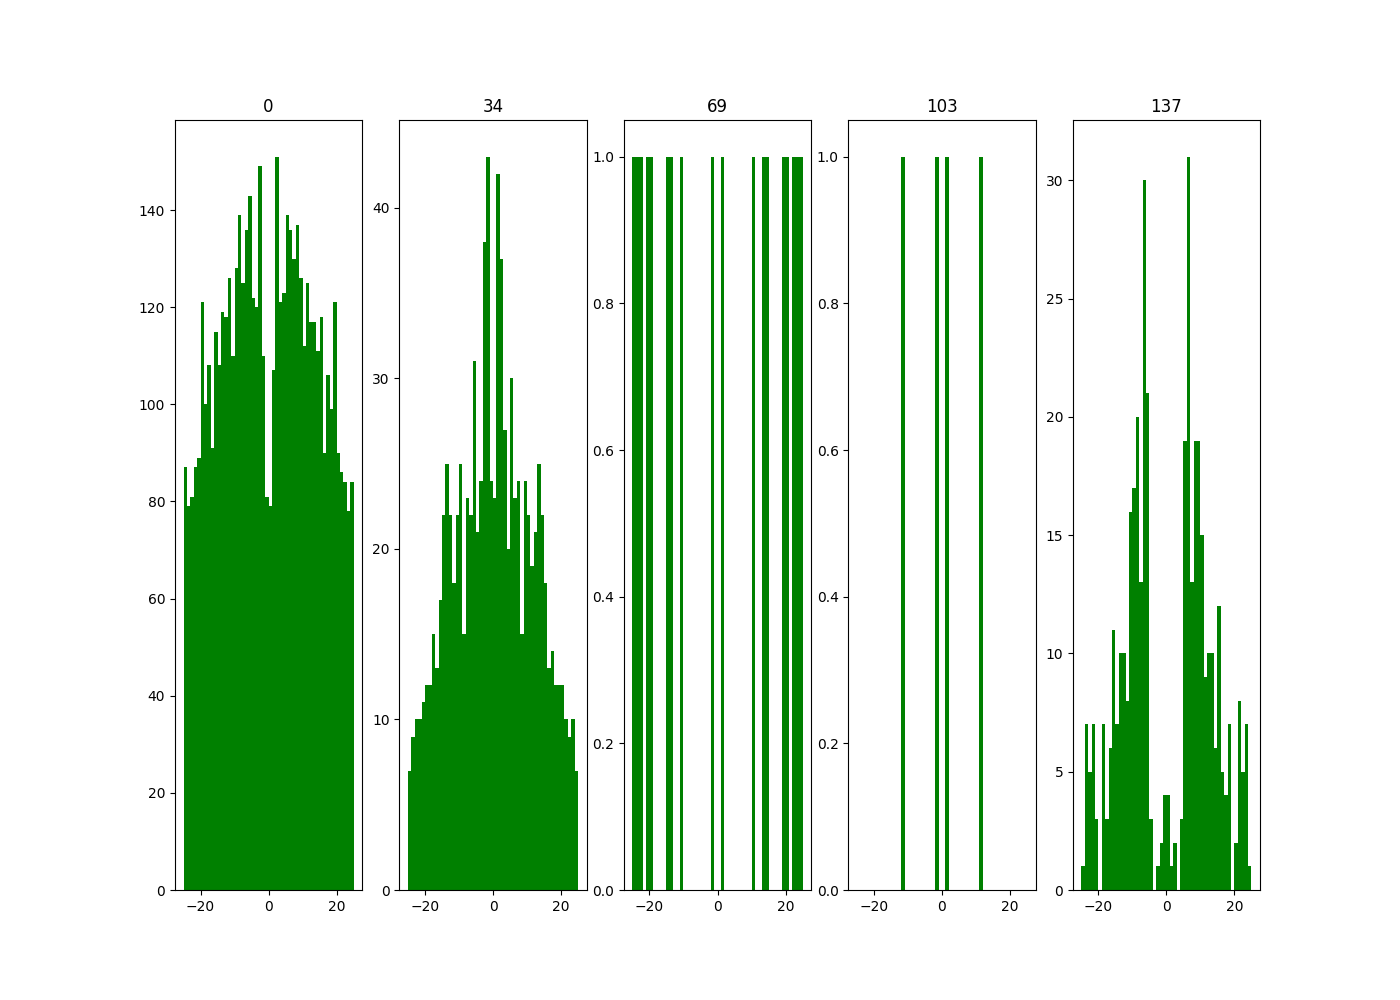

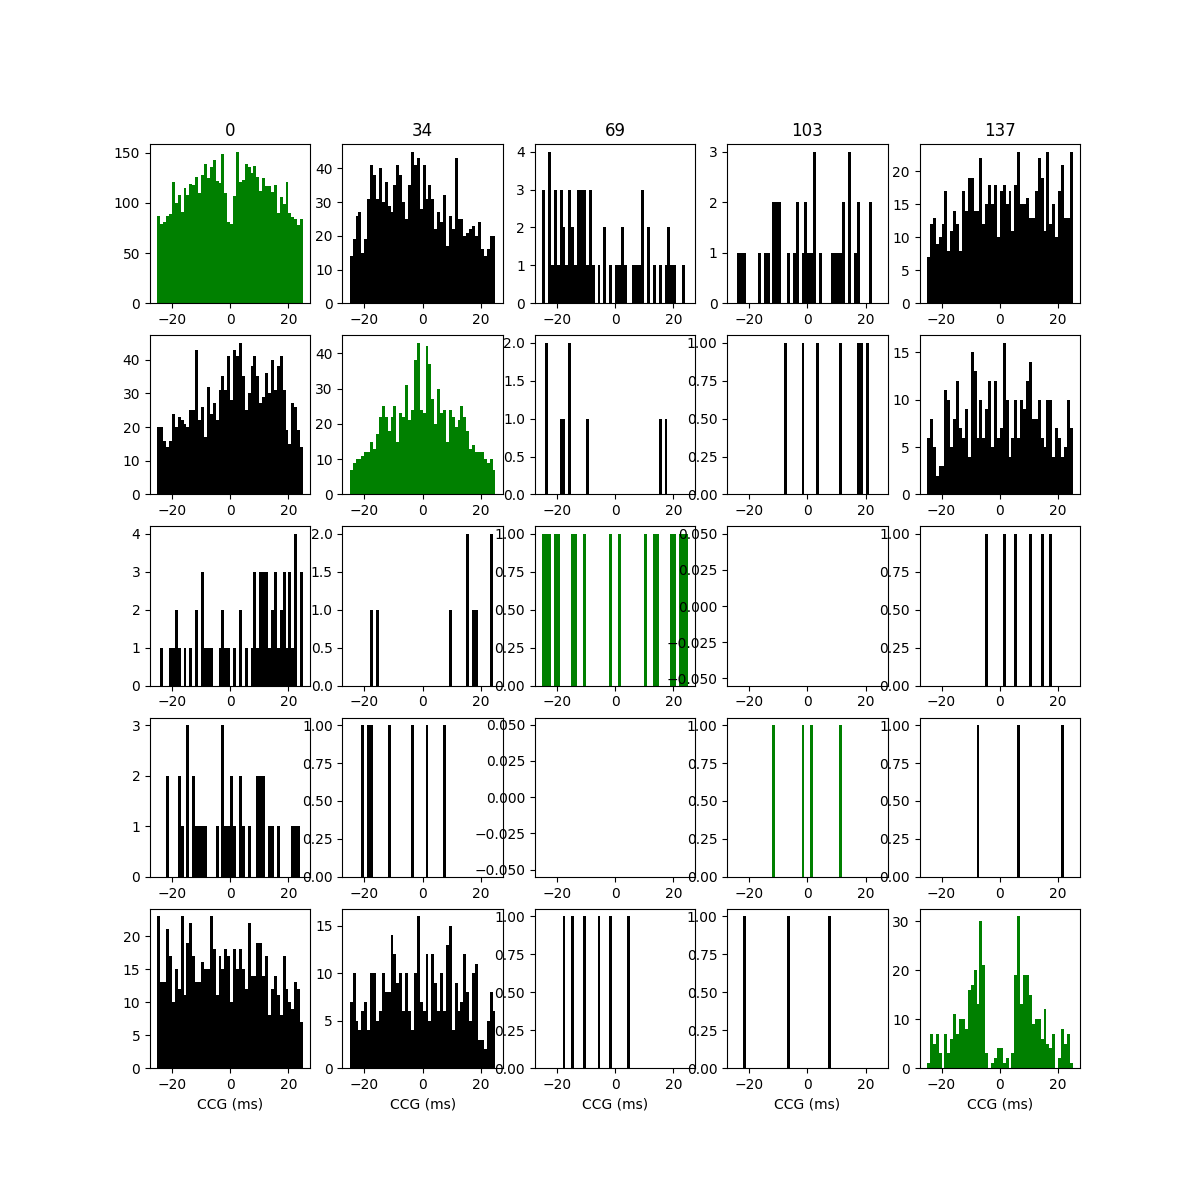

In [105]:
si.plot_autocorrelograms(we, unit_ids=sorting.unit_ids[::34], figsize=(14, 10))
si.plot_crosscorrelograms(we, unit_ids=sorting.unit_ids[::34], figsize=(12, 12))

### Compute template similarity

In [106]:
similarity = si.compute_template_similarity(we)

### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` allows one to compute several of these metrics:

In [107]:
print(si.get_template_metric_names())

['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope', 'num_positive_peaks', 'num_negative_peaks', 'velocity_above', 'velocity_below', 'exp_decay', 'spread']


In [108]:
template_metrics = si.compute_template_metrics(we)
display(template_metrics)

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope,num_positive_peaks,num_negative_peaks
0,0.000857,-0.266235,0.00031,88887.017813,-12960.426608,2,1
1,0.000947,-0.266814,0.000297,226656.397584,-41678.958489,2,1
2,0.000797,-0.328291,0.00031,134373.509091,-20587.093939,1,1
3,0.000747,-0.285943,0.000267,295207.358725,-37865.772697,1,1
4,0.000853,-0.285516,0.000233,303555.317133,-59437.486157,1,1
...,...,...,...,...,...,...,...
166,0.000877,-0.249747,0.000277,223526.094652,-30710.650084,2,1
167,0.001093,-0.184666,0.000263,96652.676067,-12574.938262,1,1
168,0.001063,-0.302432,0.000373,68649.42576,-13542.827585,2,1
169,0.00084,-0.335455,0.000323,125585.635503,-22126.73055,2,1


In [110]:
si.plot_template_metrics(we, include_metrics=["peak_to_valley", "half_width"], 
                         backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

# 7. Quality metrics and curation <a class="anchor" id="curation"></a>

The `qualitymetrics` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

See also this : https://spikeinterface.readthedocs.io/en/latest/modules/qualitymetrics.html

Let's see what metrics are available:

In [37]:
print(si.get_quality_metric_list())
print(si.get_quality_pca_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'rp_violation', 'sliding_rp_violation', 'amplitude_cutoff', 'amplitude_median', 'amplitude_cv', 'synchrony', 'firing_range', 'drift', 'sd_ratio']
['isolation_distance', 'l_ratio', 'd_prime', 'nearest_neighbor', 'nn_isolation', 'nn_noise_overlap', 'silhouette']


In [38]:
qm_params = si.get_default_qm_params()
qm_params

{'num_spikes': {},
 'firing_rate': {},
 'presence_ratio': {'bin_duration_s': 60, 'mean_fr_ratio_thresh': 0.0},
 'snr': {'peak_sign': 'neg', 'peak_mode': 'extremum'},
 'isi_violation': {'isi_threshold_ms': 1.5, 'min_isi_ms': 0},
 'rp_violation': {'refractory_period_ms': 1.0, 'censored_period_ms': 0.0},
 'sliding_rp_violation': {'min_spikes': 0,
  'bin_size_ms': 0.25,
  'window_size_s': 1,
  'exclude_ref_period_below_ms': 0.5,
  'max_ref_period_ms': 10,
  'contamination_values': None},
 'synchrony': {'synchrony_sizes': (2, 4, 8)},
 'firing_range': {'bin_size_s': 5, 'percentiles': (5, 95)},
 'amplitude_cv': {'average_num_spikes_per_bin': 50,
  'percentiles': (5, 95),
  'min_num_bins': 10,
  'amplitude_extension': 'spike_amplitudes'},
 'amplitude_cutoff': {'peak_sign': 'neg',
  'num_histogram_bins': 100,
  'histogram_smoothing_value': 3,
  'amplitudes_bins_min_ratio': 5},
 'amplitude_median': {'peak_sign': 'neg'},
 'drift': {'interval_s': 60,
  'min_spikes_per_interval': 100,
  'direction'

In [39]:
qm_params['isi_violation']['isi_threshold_ms'] = 1.1

In [40]:
metric_names = si.get_quality_metric_list()
# metric_names = si.get_quality_metric_list() + si.get_quality_pca_metric_list()
qm = si.compute_quality_metrics(we, metric_names=metric_names, verbose=True,  qm_params=qm_params, **job_kwargs)


Computing num_spikes
Computing firing_rate
Computing presence_ratio
Computing snr
Computing isi_violation
Computing rp_violation
Computing sliding_rp_violation
Computing amplitude_cutoff
Computing amplitude_median
Computing amplitude_cv
Computing synchrony
Computing firing_range
Computing drift
Computing sd_ratio


In [41]:
display(qm)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median,amplitude_cv,sync_spike_2,sync_spike_4,sync_spike_8,firing_range,drift_ptp,drift_std,drift_mad,sd_ratio
0,4975,16.583333,1.0,7.088326,0.055095,10,0.056119,9,0.08,0.004084,-43.094997,<NA>,0.023116,0.0,0.0,12.87,<NA>,<NA>,<NA>,<NA>
1,3043,10.143333,1.0,18.862654,0.485969,33,0.832483,30,<NA>,0.001061,-101.009995,<NA>,0.056523,0.0,0.0,4.41,<NA>,<NA>,<NA>,<NA>
2,3770,12.566667,1.0,10.596774,0.297425,31,0.360479,28,0.335,0.001195,-54.014999,<NA>,0.035279,0.0,0.0,6.86,<NA>,<NA>,<NA>,<NA>
3,3106,10.353333,1.0,8.724185,0.08481,6,0.098103,6,0.115,0.001051,-48.75,<NA>,0.029298,0.0,0.0,2.82,<NA>,<NA>,<NA>,<NA>
4,2090,6.966667,1.0,5.444479,0.312181,10,0.328761,8,0.31,0.00345,-27.884998,<NA>,0.041627,0.0,0.0,3.81,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,727,2.423333,1.0,4.483603,3.096072,12,1.0,11,<NA>,0.004673,-25.154999,<NA>,0.082531,0.0,0.0,3.21,<NA>,<NA>,<NA>,<NA>
251,275,0.916667,1.0,7.929429,1.803156,1,1.0,1,<NA>,<NA>,-42.704998,<NA>,0.072727,0.0,0.0,1.41,<NA>,<NA>,<NA>,<NA>
252,473,1.576667,1.0,6.282946,2.438014,4,1.0,4,<NA>,<NA>,-32.759998,<NA>,0.059197,0.0,0.0,1.81,<NA>,<NA>,<NA>,<NA>
254,242,0.806667,1.0,15.806796,4.65691,2,1.0,1,<NA>,<NA>,-83.07,<NA>,0.119835,0.0,0.0,1.21,<NA>,<NA>,<NA>,<NA>


In [42]:
si.plot_quality_metrics(we, include_metrics=["amplitude_cutoff", "presence_ratio", "isi_violations_ratio", "snr"], 
                        backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

For more information about these waveform features, we refer to the [SpikeInterface documentation](https://spikeinterface.readthedocs.io/en/latest/module_qualitymetrics.html) and to this excellent [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Automatic curation based on quality metrics

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qm` dataframe based on some thresholds.

Here, we'll only keep units with an ISI violation threshold and amplitude cutoff below a user-defined threshold:

In [43]:
isi_viol_thresh = 0.5
amp_cutoff_thresh = 0.1

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [44]:
our_query = f"amplitude_cutoff < {amp_cutoff_thresh} & isi_violations_ratio < {isi_viol_thresh}"
print(our_query)

amplitude_cutoff < 0.1 & isi_violations_ratio < 0.5


and then we can use the query to select units:

In [45]:
keep_units = qm.query(our_query)
keep_unit_ids = keep_units.index.values
keep_unit_ids

array([  0,   1,   2,   3,   4,   6,   7,   8,  13,  14,  20,  30,  32,
        34,  44,  45,  59,  64,  70,  71,  74,  75,  76,  83,  89,  91,
        94,  97, 100, 108, 118, 119, 124, 129, 133, 141, 145, 170, 176,
       180, 183, 193, 194, 200, 204, 218, 222, 226, 228, 239, 247])

In [46]:
sorting_auto_KS25 = sorting.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_KS25.get_unit_ids())}")

Number of units before curation: 240
Number of units after curation: 51


We can also save all the waveforms and post-processed data for curated units in a separate folder:

In [47]:
we_curated = we.select_units(keep_unit_ids, new_folder=base_folder / "waveforms_curated")

TypeError: MockWaveformExtractor.select_units() got an unexpected keyword argument 'new_folder'

In [122]:
print(we_curated)

WaveformExtractor: 47 channels - 33 units - 1 segments
  before:30 after:60 n_per_units:500 - sparse


In [123]:
%matplotlib widget
si.plot_unit_templates(we_curated, backend='ipywidgets')

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

In [124]:
we_curated.get_available_extension_names()

['template_metrics',
 'similarity',
 'principal_components',
 'spike_amplitudes',
 'correlograms',
 'spike_locations',
 'unit_locations',
 'quality_metrics']

# 8. Viewers <a class="anchor" id="viewers"></a>


### SpikeInterface GUI

A QT-based GUI built on top of SpikeInterface objects.

Developed by Samuel Garcia, CRNL, Lyon.

In [135]:
# !sigui {base_folder}/waveforms_sparse

### Sorting Summary - SortingView

The `sortingview` backend requires an additional step to configure the transfer of the data to be plotted to the cloud. 

See documentation [here](https://spikeinterface.readthedocs.io/en/latest/module_widgets.html).

Developed by Jeremy Magland and Jeff Soules, Flatiron Institute, NYC

In [127]:
w = si.plot_sorting_summary(we_curated, backend="sortingview")

https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://2a2cc53d21a7677c130fda6436c5839184f3e974

`sortingview` can also be used for manual curation and labeling of units!

In [136]:
# w = si.plot_sorting_summary(we_curated, backend="sortingview", curation=True)

https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://61648243fcfd694dd6b179bc85626db03675a36f

You can apply the `sortingview` curation file with:

`sorting_manual_curated = si.apply_sortingview_curation(we_curated.sorting, uri_or_json="curation.json")`

# 9. Spike sorting comparison <a class="anchor" id="comparison"></a>

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the `comparison` module.
We first compare and match the output spike trains of the different sorters, and we can then extract a new `Sorting` with only the units in agreement.

In [125]:
sorting_KS25 = si.read_sorter_folder(base_folder/"results_KS25")
sorting_KS2 = si.read_sorter_folder(base_folder/"results_KS2")

### Compare two sorters

In [126]:
comp_KS2_KS25 = si.compare_two_sorters(sorting_KS2, sorting_KS25, 'KS2', 'KS25')

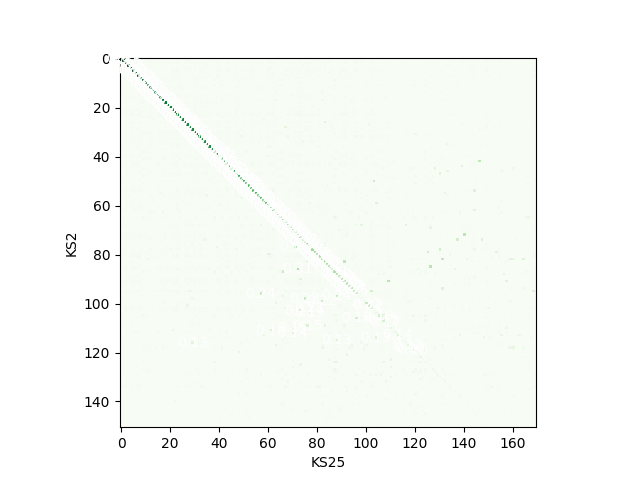

In [127]:
si.plot_agreement_matrix(comp_KS2_KS25, unit_ticks=False)

In [128]:
comp_KS2_KS25auto = si.compare_two_sorters(sorting_KS2, sorting_auto_KS25, 'KS2', 'KS25_auto')

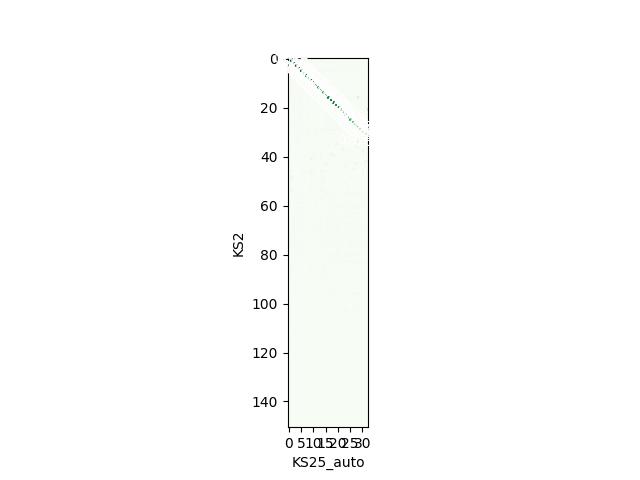

In [129]:
si.plot_agreement_matrix(comp_KS2_KS25auto, unit_ticks=False)

### Compare multiple sorters

In 2020, the spike interface team publish an article to demonstrate that sorters do not agree on the results.
See this https://elifesciences.org/articles/61834

Here is a direct illustration of the phenomenom on this dataset.

In [130]:
mcmp = si.compare_multiple_sorters([sorting_KS2, sorting_KS25], ['KS2', 'KS25'], 
                                   spiketrain_mode='union', verbose=True)

Multicomaprison step 1: pairwise comparison
  Comparing: KS2 and KS25
Multicomparison step 2: make graph
Multicomaprison step 3: clean graph
Removed 0 duplicate nodes
Multicomparison step 4: extract agreement from graph


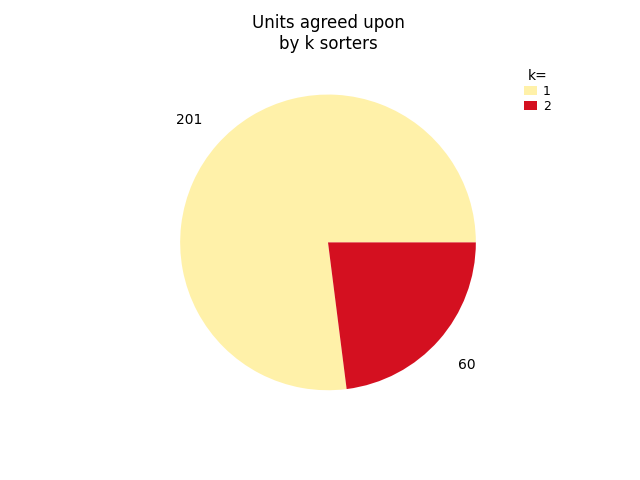

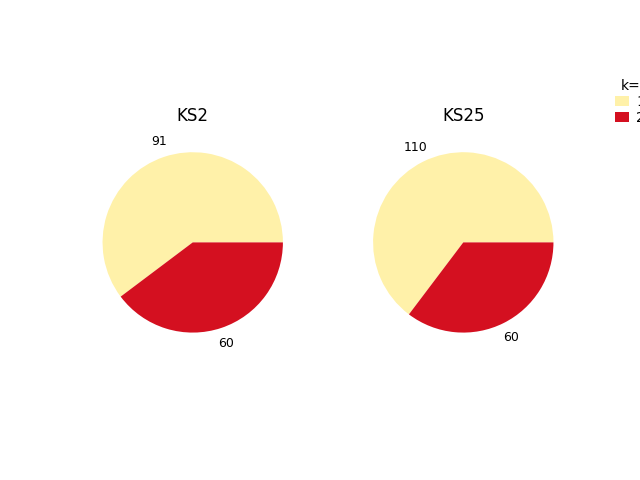

In [131]:
w = si.plot_multicomparison_agreement(mcmp)
w = si.plot_multicomparison_agreement_by_sorter(mcmp)

In [132]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)
print(agreement_sorting)

AgreementSortingExtractor: 60 units - 1 segments - 30.0kHz


# 10. Exporters <a class="anchor" id="exporters"></a>

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [133]:
si.export_to_phy(we, output_folder=base_folder / 'phy_KS25', 
                 compute_amplitudes=False, compute_pc_features=False, copy_binary=False,
                 **job_kwargs)

Run:
phy template-gui  /data_local/DataSpikeSorting/SI_tutorial_cambridgeneurotech_2023/phy_KS25/params.py


![phy](./phy.png)

After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

`sorting_phy_curated = si.read_phy(base_folder / 'phy_KS25/', exclude_cluster_groups=['noise'])`

## Export a report to a folder



In [ ]:
si.export_report(we, output_folder=base_folder / 'report_KS25')

### Et voilà!